Load data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# download streetstyle data
!wget https://s3.amazonaws.com/kmatzen/streetstyle27k.tar

--2019-05-20 20:37:40--  https://s3.amazonaws.com/kmatzen/streetstyle27k.tar
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2464604160 (2.3G) [application/x-tar]
Saving to: ‘streetstyle27k.tar’

streetstyle27k.tar  100%[===================>]   2.29G  71.9MB/s    in 36s     

2019-05-20 20:38:16 (65.1 MB/s) - ‘streetstyle27k.tar’ saved [2464604160/2464604160]



In [0]:
# Extracting zip file
!tar xvf streetstyle27k.tar

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# get the attribution files
!wget https://s3.amazonaws.com/kmatzen/streetstyle27k.manifest

--2019-05-20 20:39:55--  https://s3.amazonaws.com/kmatzen/streetstyle27k.manifest
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.176.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.176.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6843031 (6.5M) [text/plain]
Saving to: ‘streetstyle27k.manifest.1’

streetstyle27k.mani 100%[===================>]   6.53M  26.9MB/s    in 0.2s    

2019-05-20 20:39:56 (26.9 MB/s) - ‘streetstyle27k.manifest.1’ saved [6843031/6843031]



In [0]:
#!rm -r data
!mkdir data
!mv streetstyle27k data/streetstyle27k
!mv streetstyle27k.manifest data/streetstyle27k.manifest
#!mv streetstyle27k.tar '/content/gdrive/My Drive/colab/data/'

#%cd ./data/images
#%cd ../
#!rm streetstyle27k.tar.1

In [0]:
#!ls -l '/content/gdrive/My Drive/colab'

total 2578
-rw------- 1 root root   1820 May 10 20:30  bbox_all_images.py
-rw------- 1 root root 481084 May 11 21:16 'Copy of createDB.ipynb'
-rw------- 1 root root 836200 May 11 21:13 'Copy of yolo.ipynb'
-rw------- 1 root root 481148 May 11 20:52  createDB.ipynb
drwx------ 2 root root   4096 May  8 17:51  data
-rw------- 1 root root 834001 May 11 20:46  yolo.ipynb


plot an image

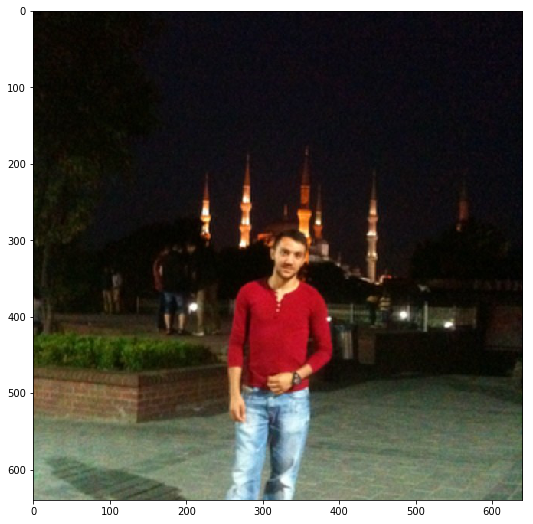

In [0]:
import matplotlib.pyplot as plt
from PIL import Image

fig=plt.figure(figsize=(16, 9))
filename = 'data/streetstyle27k/d/f/f/dff8b1017226167906804e492526d9e6_726861536941066133_632544368.jpg'

img=Image.open(filename)
plt.imshow(img)


Preprocess Data

In [0]:
from PIL import Image
import os
from matplotlib import pyplot as plt
import pandas as pd
import fastai
from fastai.vision import *
from tqdm import tqdm
import numpy as np


In [0]:
#!ls -l 
 

total 2406856
drwxr-xr-x 3 root root       4096 May 11 21:24 data
drwx------ 3 root root       4096 May 11 21:14 gdrive
drwxr-xr-x 1 root root       4096 May  8 16:22 sample_data
-rw-r--r-- 1 root root 2464604160 Sep  4  2017 streetstyle27k.tar


Setting

In [0]:
#below functions are created by platform-demo2, with several modifications
np.random.seed(1)
labels = pd.read_csv('data/streetstyle27k.manifest')

crop_imgs = False
generate_new_boxes = False

test_pct = 0.1
valid_pct = 0.1

In [0]:
#create multilabels
pattern_na = labels['clothing_pattern'].isna()
color_na = labels['major_color'].isna()
sleeve_length_na = labels['sleeve_length'].isna()
neckline_shape_na = labels['neckline_shape'].isna()
clothing_category_na = labels['clothing_category'].isna()
multiple_layers_na = labels['multiple_layers'].isna()

necktie_yes = ~labels['wearing_necktie'].isna() & (labels['wearing_necktie'] == 'Yes')
collar_presence_yes = ~labels['collar_presence'].isna() & (labels['collar_presence'] == 'Yes')
wearing_scarf_yes = ~labels['wearing_scarf'].isna() & (labels['wearing_scarf'] == 'Yes')
wearing_jacket_yes = ~labels['wearing_jacket'].isna() & (labels['wearing_jacket'] == 'Yes')
wearing_hat_yes = ~labels['wearing_hat'].isna() & (labels['wearing_hat'] == 'Yes')
wearing_glasses_yes = ~labels['wearing_glasses'].isna() & (labels['wearing_glasses'] == 'Yes')

res = []

for i in tqdm(labels.index, position=0):
    
    temp = []
    
    if not pattern_na[i]: temp.append(labels['clothing_pattern'][i])
    if not color_na[i]: temp.append(labels['major_color'][i])
    if not sleeve_length_na[i]: temp.append(labels['sleeve_length'][i])
    if not neckline_shape_na[i]: temp.append(labels['neckline_shape'][i])
    if not clothing_category_na[i]: temp.append(labels['clothing_category'][i])
    if not multiple_layers_na[i]: temp.append(labels['multiple_layers'][i])

    if necktie_yes[i]: temp.append('necktie')
    if collar_presence_yes[i]: temp.append('collar_presence')
    if wearing_scarf_yes[i]: temp.append('wearing_scarf')
    if wearing_jacket_yes[i]: temp.append('wearing_jacket')
    if wearing_hat_yes[i]: temp.append('wearing_hat')
    if wearing_glasses_yes[i]: temp.append('wearing_glasses')
       
    res.append(';'.join(temp))
print(res[:2])

100%|██████████| 27087/27087 [00:04<00:00, 5468.51it/s]

['Solid;Red;Long sleeve;One layer', 'Graphics;White;Short sleeve;Round;Shirt;One layer']


In [0]:
#!ls -l 'data/all'
#!ls -l 'data/streetstyle27k/d/f/f'
#!ls -l data

#!mv data/all '/content/gdrive/My Drive/colab/data/'

total 8
drwxr-xr-x  5 root root 4096 May 13 18:13 all
drwxr-xr-x 18 root root 4096 May 13 17:11 streetstyle27k


DataTable transformation

In [0]:
def create_old_fn(x):
    a, b, c = x[:3]
    return a+'/'+b+'/'+c+'/'+x

def create_new_fn(x):
    return x

labels['old_file'] = labels['url'].apply(lambda x: x.replace('https://s3.amazonaws.com/stylyze/', '')).apply(create_old_fn)
labels['file'] = labels['url'].apply(lambda x: x.replace('https://s3.amazonaws.com/stylyze/', '')).apply(create_new_fn)
labels['url'] = 'data/streetstyle27k/'+ labels['old_file']

In [0]:
labels['label'] = res
ds_type = np.random.choice(['train', 'valid', 'test'], size = len(labels.index), p = [1-test_pct-valid_pct, valid_pct, test_pct])
labels['valid'] = ds_type == 'valid'
labels['test'] = ds_type == 'test'

start_cols = ['file', 'label', 'valid', 'test']
end_cols = [x for x in labels.columns if x not in start_cols]
labels = labels[start_cols + end_cols]

labels.sample(3).transpose()

,8586,11066,16916
file,4b6a29e2002e9febeb17f4579efdcd7b_5861765210623...,a74bbe1251b330057ab711cb8b07a9c4_5163623430395...,7c38c6eab48ff7c0fd0b256771a2c585_7116688712691...
label,Solid;Gray;Long sleeve;Folded;Outerwear;Multip...,Floral;No sleeve;Dress;One layer,Solid;Blue;Short sleeve;Folded;Shirt;One layer...
valid,False,False,True
test,False,False,False
id,3812406,3718381,3799068
url,data/streetstyle27k/4/b/6/4b6a29e2002e9febeb17...,data/streetstyle27k/a/7/4/a74bbe1251b330057ab7...,data/streetstyle27k/7/c/3/7c38c6eab48ff7c0fd0b...
created_time,2013-11-10 15:35:08+00,2013-08-06 07:46:49+00,2014-05-02 19:06:02+00
city_id,11,14,30
month_id,2013_11,2013_8,2014_5
lat,24.8521,51.5221,50.4206


generate new bounding boxes

In [17]:
!pip install gluoncv
!pip install mxnet

     |████████████████████████████████| 348kB 3.4MB/s 
     |████████████████████████████████| 28.4MB 1.2MB/s 
     |████████████████████████████████| 13.8MB 35.7MB/s 
ERROR: spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: fastai 1.0.52 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.3
    Uninstalling numpy-1.16.3:
      Successfully uninstalled numpy-1.16.3
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
from gluoncv import model_zoo, data, utils

net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)
net.reset_class(classes=['person'], reuse_weights=['person'])

Model file is not found. Downloading.


223070KB [00:04, 47309.00KB/s]                            


In [0]:
def get_box(image_path):
    #print(image_path)
    x, img = data.transforms.presets.yolo.load_test(image_path, short=640)
    class_IDs, scores, bounding_boxes = net(x)
    cid = int(class_IDs[0][0].asnumpy())
    #cname = net.classes[cid]
    #score = float(scores[0][0].asnumpy())
    x1,y1,x2,y2 = bbox =  bounding_boxes[0][0].astype(int).asnumpy()
    x2,y2 = min(x2,640),min(y2,640)
    return bbox
    
def bbox_all_images():
    x1s,y1s,x2s,y2s = [],[],[],[]
    for i in tqdm(labels.index, position=0): 
        url = labels['url'][i]
        x1, y1, x2, y2 = get_box(url)
   
        x1s.append(x1)
        y1s.append(y1)
        x2s.append(x2)
        y2s.append(y2)
        
        path = Path('/content/gdrive/My Drive/colab/data/db/')
        if i % 30 == 0: 
            print(i)
            np.savez(path/'bboxes', x1s=x1s,y1s=y1s, x2s=x2s,y2s=y2s)
    
   
    labels['new_x1'],labels['new_y1'],labels['new_x2'],labels['new_y2'] = x1s,y1s,x2s,y2s
    
    print('Done')
   

if generate_new_boxes:bbox_all_images()

  0%|          | 0/27087 [00:00<?, ?it/s]

data/streetstyle27k/d/f/f/dff8b1017226167906804e492526d9e6_726861536941066133_632544368.jpg


  0%|          | 1/27087 [00:03<28:14:14,  3.75s/it]

data/streetstyle27k/d/2/f/d2ff74a75e0ff19ed59e411beda2ec68_699743141718168270_348847083.jpg


KeyboardInterrupt: ignored

save images to training and testing for data Bunch

In [0]:
#!rm -r 'data/all'
!mkdir 'data/all'
!mkdir 'data/all/train'
!mkdir 'data/all/test'
!mkdir 'data/cropped'
!mkdir 'data/cropped/train'
!mkdir 'data/cropped/test'

import shutil
from PIL import Image

shape = (320,320)

path = Path('')

crop_imgs = True

for i in tqdm(labels.index, position=0): 
    url = labels['url'][i]
    #if labels['test'][i]: shutil.copy2(url,'data/all/test')
    #elif labels['valid'][i]: shutil.copy2(url,'data/all/valid')
    #else: shutil.copy2(url,'data/all/train')
      
    if crop_imgs:
        im = Image.open(url)
        if generate_new_boxes:
            x1,y1,x2,y2 = labels['new_x1'][i],labels['new_y1'][i],labels['new_x2'][i],labels['new_y2'][i]
        else:
            x1,y1,x2,y2 = labels['x1'][i],labels['y1'][i],labels['x2'][i],labels['y2'][i]
        cropped = im.crop((x1,y1,x2,y2))
        cropped = cropped.resize(shape)
        trainfile = 'data/cropped/train/' + labels['file'][i]
        testfile = 'data/cropped/test/' + labels['file'][i]
        if labels['test'][i]:cropped.save(testfile)
        else: cropped.save(trainfile)
        im.close()
        cropped.close()
    else:
        if labels['test'][i]: shutil.copy2(url,'data/all/test')
        #elif labels['valid'][i]: shutil.copy2(url,'data/all/valid')
        else: shutil.copy2(url,'data/all/train')
    


100%|██████████| 27087/27087 [04:58<00:00, 79.56it/s]


In [16]:
#!zip -r cro.zip data/cropped/

Output hidden; open in https://colab.research.google.com to view.

save labels

In [0]:
path = Path('/content/gdrive/My Drive/colab/data/db/')
labels.to_csv(path/'labels.csv', index=False)